# VAR on US data

## 0.1 Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as plt

from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()

In [2]:
# load specific forecasting tools

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# visualization correlation
import seaborn as sns

# datatime
import datetime
from datetime import datetime
from datetime import timedelta
import time
from dateutil.relativedelta import relativedelta

## 0.2 Macroeconomic data

In [3]:
dataUS = pd.read_csv('dfmacrodata.csv', sep = ',')
dataUS['mdate']= pd.to_datetime(dataUS.mdate)
dataUS = dataUS.set_index('mdate').asfreq('MS')
dataUS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349 entries, 1991-01-01 to 2020-01-01
Freq: MS
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   infUS      349 non-null    float64
 1   intrateUS  349 non-null    float64
 2   M2US       349 non-null    float64
 3   urateUS    349 non-null    float64
 4   RERUS      349 non-null    float64
 5   realWUS    349 non-null    float64
dtypes: float64(6)
memory usage: 19.1 KB


In [4]:
df = dataUS # to work with dataframe called 'df'

## 1. Correlation

looking at the correlation as a mean of visualization.

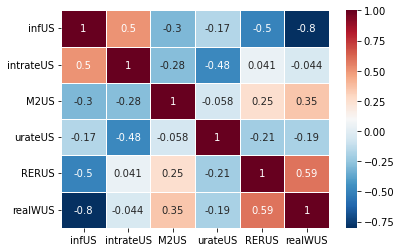

In [5]:
pearsoncorr = dataUS.corr(method='pearson')
sns.heatmap(pearsoncorr,
xticklabels=pearsoncorr.columns,
yticklabels=pearsoncorr.columns,
cmap='RdBu_r',
annot=True,
linewidth=0.5)
plt.show()

## 2. Test for stationarity

In [6]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
adf_test(df["infUS"], "infUS")   # stationary
adf_test(df["intrateUS"], "intrateUS") # non-stationary
adf_test(df["M2US"], "M2US")         # non-stationary
adf_test(df["urateUS"], "urateUS")   # non-stationary
adf_test(df["RERUS"], "RERUS")       # stationary
adf_test(df["realWUS"], "realWUS")   # Stationary

Augmented Dickey-Fuller Test: infUS
ADF test statistic       -3.511227
p-value                   0.007703
# lags used              16.000000
# observations          332.000000
critical value (1%)      -3.450201
critical value (5%)      -2.870285
critical value (10%)     -2.571429
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: intrateUS
ADF test statistic       -1.990315
p-value                   0.290836
# lags used              11.000000
# observations          337.000000
critical value (1%)      -3.449904
critical value (5%)      -2.870155
critical value (10%)     -2.571360
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: M2US
ADF test statistic       -2.240623
p-value                   0.191833
# lags used              12.000000
# observations          336.000000
critical value (1%)      -3.

In [8]:
# taking the first difference
df["intrateUS_diff"] = df["intrateUS"] - df["intrateUS"].shift()
df["M2US_diff"] = df["M2US"] - df["M2US"].shift()
df["urateUS_diff"] = df["urateUS"] - df["urateUS"].shift()

# series are stationary in first diff
adf_test(df["intrateUS_diff"], "intrate_diff") # stationary
adf_test(df["M2US_diff"], "M2US_diff")         # stationary
adf_test(df["urateUS_diff"], "urateUS_diff")   # stationary

Augmented Dickey-Fuller Test: intrate_diff
ADF test statistic       -4.418162
p-value                   0.000276
# lags used              10.000000
# observations          337.000000
critical value (1%)      -3.449904
critical value (5%)      -2.870155
critical value (10%)     -2.571360
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: M2US_diff
ADF test statistic     -8.100691e+00
p-value                 1.302311e-12
# lags used             1.100000e+01
# observations          3.360000e+02
critical value (1%)    -3.449963e+00
critical value (5%)    -2.870181e+00
critical value (10%)   -2.571373e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: urateUS_diff
ADF test statistic       -3.758126
p-value                   0.003366
# lags used               5.000000
# observations          342.000000
critical

In [9]:
df_stat2 = df.drop(["intrateUS", "M2US","urateUS"], axis=1)
df_stat = df_stat2[1:] # drop first row, because of NaN after first diff.
df_stat.describe()
df_stat.head()
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1991-02-01 to 2020-01-01
Freq: MS
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   infUS           348 non-null    float64
 1   RERUS           348 non-null    float64
 2   realWUS         348 non-null    float64
 3   intrateUS_diff  348 non-null    float64
 4   M2US_diff       348 non-null    float64
 5   urateUS_diff    348 non-null    float64
dtypes: float64(6)
memory usage: 19.0 KB


In [10]:
df_stat.head()

,infUS,RERUS,realWUS,intrateUS_diff,M2US_diff,urateUS_diff
mdate,,,,,,
1991-02-01,0.053125,-0.052432,-0.023451,-0.0066,0.001235,0.002
1991-03-01,0.048212,-0.065464,-0.014615,-0.0013,0.001903,0.002
1991-04-01,0.048099,-0.045947,-0.015619,-0.0021,-0.000461,-0.001
1991-05-01,0.050349,-0.034684,-0.019956,-0.0013,0.003637,0.002
1991-06-01,0.046959,-0.020812,-0.015648,0.0012,-0.001488,0.000


## 3. Train-Test Split

In [11]:
time_split= pd.to_datetime('2019-01-01') # selecting the the cut-off month to be the 01.01.2019
train = df_stat.loc[df_stat.index < time_split] # data before 01.01.2019
train.describe()
valid = df_stat.loc[df_stat.index >= time_split] # data since (and including) 01.01.2019
valid.describe()

,infUS,RERUS,realWUS,intrateUS_diff,M2US_diff,urateUS_diff
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.018605,0.033811,0.016662,-0.000554,0.002363,-0.000231
std,0.002765,0.024909,0.003916,0.001232,0.003336,0.001166
min,0.014817,-0.005288,0.008599,-0.002800,-0.003921,-0.002000
25%,0.017273,0.015905,0.015769,-0.000900,0.000408,-0.001000
50%,0.018128,0.025205,0.017647,0.000000,0.002556,0.000000
75%,0.020056,0.059982,0.019651,0.000100,0.004003,0.001000
max,0.024605,0.064525,0.020309,0.001300,0.008766,0.001000


## 4. Grid Search for Order P

In [12]:
train.describe()
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 1991-02-01 to 2018-12-01
Freq: MS
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   infUS           335 non-null    float64
 1   RERUS           335 non-null    float64
 2   realWUS         335 non-null    float64
 3   intrateUS_diff  335 non-null    float64
 4   M2US_diff       335 non-null    float64
 5   urateUS_diff    335 non-null    float64
dtypes: float64(6)
memory usage: 18.3 KB


In [13]:
model = VAR(train)

In [14]:
x = model.select_order(maxlags=14)
x.summary()

,AIC,BIC,FPE,HQIC
0,-61.74,-61.67,1.543e-27,-61.71
1,-69.14,-68.65,9.350e-31,-68.95
2,-69.62,-68.71*,5.799e-31,-69.26*
3,-69.74,-68.40,5.148e-31,-69.21
4,-69.73,-67.96,5.237e-31,-69.02
5,-69.72,-67.53,5.303e-31,-68.84
6,-69.73,-67.12,5.253e-31,-68.69
7,-69.67,-66.64,5.596e-31,-68.46
8,-69.60,-66.14,6.034e-31,-68.22
9,-69.54,-65.66,6.415e-31,-67.99


In [15]:
x = model.select_order(maxlags=11)
x.summary()

,AIC,BIC,FPE,HQIC
0,-61.75,-61.68,1.518e-27,-61.72
1,-69.15,-68.66,9.308e-31,-68.95
2,-69.63,-68.72*,5.759e-31,-69.27*
3,-69.76,-68.43,5.074e-31*,-69.23
4,-69.74,-67.99,5.151e-31,-69.04
5,-69.74,-67.57,5.189e-31,-68.87
6,-69.76*,-67.17,5.095e-31,-68.72
7,-69.70,-66.69,5.437e-31,-68.49
8,-69.63,-66.20,5.808e-31,-68.27
9,-69.58,-65.73,6.158e-31,-68.05


##### With a max of 14 lags: 
AIC and FPE suggest 13 lags, while BIC and HQIC are more restrictive and suggest 2, respectively 3 lags. \
With a max of 11 lags: \
AIC and FPE suggests 6 lags, respectively 3 lags. \
--> We choose 5 lags, since this model is restricive as well as minimizing the AIC.

In [16]:
model_fitted=model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Jun, 2022
Time:                     20:39:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -67.2067
Nobs:                     329.000    HQIC:                  -68.7464
Log likelihood:           8897.88    FPE:                5.04134e-31
AIC:                     -69.7682    Det(Omega_mle):     2.65971e-31
--------------------------------------------------------------------
Results for equation infUS
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000784         0.000890            0.881           0.378
L1.infUS                  1.442134         0.136018           10.603           0.000
L1.RERUS                 -0.008496         0

## 5. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [17]:
train.columns
train.tail()

,infUS,RERUS,realWUS,intrateUS_diff,M2US_diff,urateUS_diff
mdate,,,,,,
2018-08-01,0.026780,0.026189,0.002950,0.0000,-0.000762,0.000
2018-09-01,0.023552,0.046269,0.008910,0.0004,-0.001230,-0.001
2018-10-01,0.025285,0.054270,0.009353,0.0024,-0.003149,0.001
2018-11-01,0.021728,0.043994,0.013698,0.0001,-0.001049,-0.001
2018-12-01,0.019152,0.053419,0.014390,0.0007,0.004871,0.002


In [18]:
def adjust(val, length= 6): return str(val).ljust(length)

In [19]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(train.columns, out):
    print(adjust(col), ':', round(val, 3))

infUS  : 1.993
RERUS  : 1.999
realWUS : 1.997
intrateUS_diff : 1.978
M2US_diff : 1.996
urateUS_diff : 2.032


All statistics are close to 2, hence the serial correlation seems quite alright.

In [20]:
model_fitted.test_normality().summary()

Test statistic,Critical value,p-value,df
591.2,21.03,0.000,12


In [21]:
model_fitted.test_whiteness().summary()

Test statistic,Critical value,p-value,df
211.0,173.0,0.000,144


These last two tests reject the H0 of normality but are known to have low power.

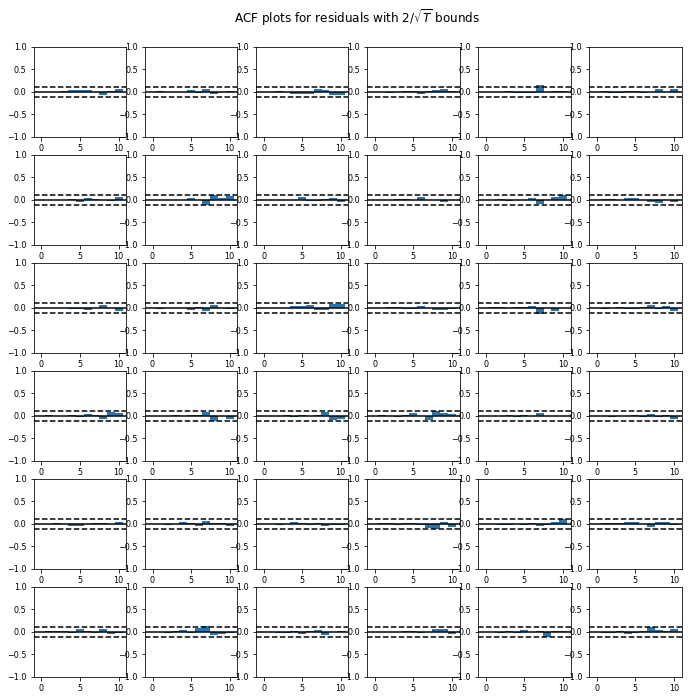

In [22]:
model_fitted.plot_acorr()
plt.savefig("var_ACF.pdf")

## 5.2 Impulse Response Analysis

Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix
and hence interpretations may change depending on variable ordering.\
We use orth=False, because we do not want to make any inference about the ordering of the variables.

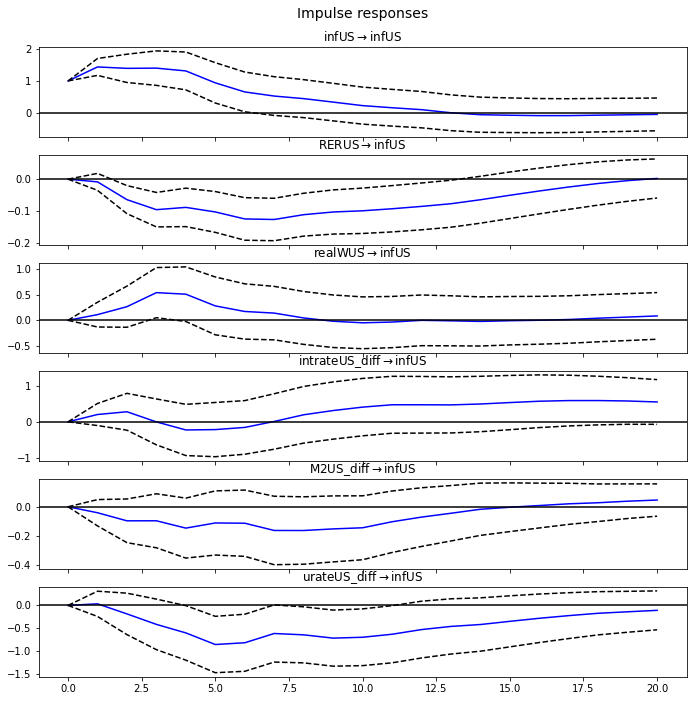

In [23]:
irf = model_fitted.irf(20)
irf.plot(orth=False, response='infUS')
plt.savefig("var_irf.pdf")

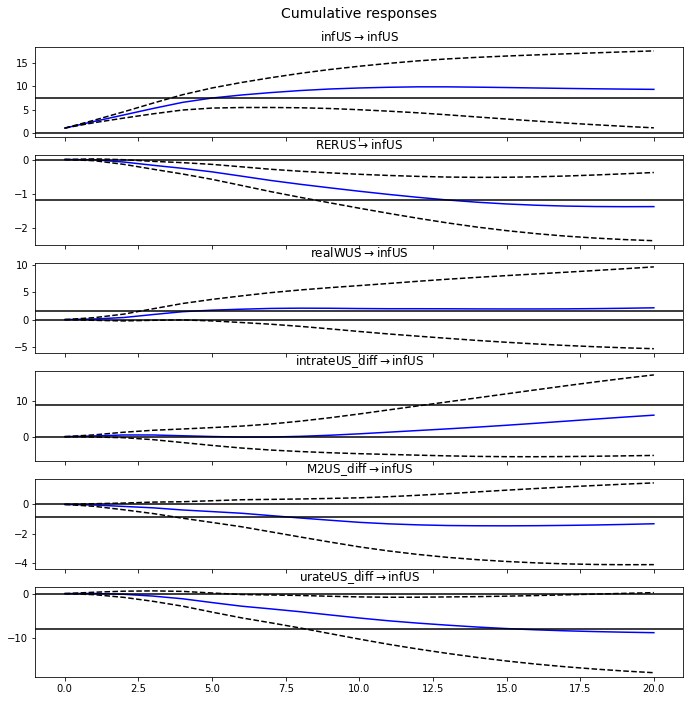

In [24]:
irf.plot_cum_effects(orth=False, response='infUS') # Cumulative IRF of inflation
plt.savefig("var_irf_cum.pdf")

## 6. Forecast

In [25]:
# Get the lag order
lag_order = model_fitted.k_ar
lag_order

6

In [26]:
# get length to forecast
fc_len=len(valid)
fc_len

13

In [27]:
# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

array([[ 2.89875247e-02,  8.07095271e-03,  1.76778962e-03,
         9.00000000e-04, -2.21644193e-03, -2.00000000e-03],
       [ 2.67799970e-02,  2.61891037e-02,  2.94973275e-03,
         0.00000000e+00, -7.61712705e-04,  0.00000000e+00],
       [ 2.35518494e-02,  4.62687735e-02,  8.90982781e-03,
         4.00000000e-04, -1.22996051e-03, -1.00000000e-03],
       [ 2.52852497e-02,  5.42697853e-02,  9.35262701e-03,
         2.40000000e-03, -3.14898114e-03,  1.00000000e-03],
       [ 2.17280536e-02,  4.39943679e-02,  1.36979554e-02,
         1.00000000e-04, -1.04854443e-03, -1.00000000e-03],
       [ 1.91521559e-02,  5.34188873e-02,  1.43898834e-02,
         7.00000000e-04,  4.87084269e-03,  2.00000000e-03]])

Let's forecast:

In [28]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=fc_len)
df_fc = pd.DataFrame(fc, index=valid.index[:], columns=train.columns)
df_fc

,infUS,RERUS,realWUS,intrateUS_diff,M2US_diff,urateUS_diff
mdate,,,,,,
2019-01-01,0.018988,0.061968,0.016280,0.000195,0.003278,-0.000323
2019-02-01,0.018540,0.067841,0.016931,0.000111,0.002139,0.000769
2019-03-01,0.016104,0.069405,0.019403,0.000455,0.000668,-0.000093
2019-04-01,0.015677,0.067119,0.019910,0.000599,-0.000619,0.000404
2019-05-01,0.016879,0.063205,0.018423,0.000077,-0.000117,0.000171
2019-06-01,0.017415,0.056515,0.017549,0.000248,0.000356,0.000159
2019-07-01,0.017077,0.049519,0.017959,0.000040,-0.000287,-0.000096
2019-08-01,0.017409,0.043106,0.017412,0.000005,-0.000034,0.000147
2019-09-01,0.018088,0.035100,0.016666,-0.000094,-0.000379,-0.000140


## 7. Invert the transformation to get the real forecast

In [29]:
columns = df[['intrateUS', 'M2US', 'urateUS']].columns

for col in columns:
    # roll back 1st diff
    df_fc[str(col)] = train[str(col) + '_diff'].iloc[-1] + df_fc[str(col)+'_diff'].cumsum()
df_fc2 = df_fc.loc[:, ~df_fc.columns.str.contains('_diff$')]
df_forecast = df_fc2.add_suffix('_fc')
df_forecast

,infUS_fc,RERUS_fc,realWUS_fc,intrateUS_fc,M2US_fc,urateUS_fc
mdate,,,,,,
2019-01-01,0.018988,0.061968,0.016280,0.000895,0.008149,0.001677
2019-02-01,0.018540,0.067841,0.016931,0.001006,0.010288,0.002446
2019-03-01,0.016104,0.069405,0.019403,0.001461,0.010956,0.002353
2019-04-01,0.015677,0.067119,0.019910,0.002060,0.010337,0.002758
2019-05-01,0.016879,0.063205,0.018423,0.002138,0.010220,0.002929
2019-06-01,0.017415,0.056515,0.017549,0.002386,0.010576,0.003088
2019-07-01,0.017077,0.049519,0.017959,0.002426,0.010288,0.002991
2019-08-01,0.017409,0.043106,0.017412,0.002431,0.010255,0.003138
2019-09-01,0.018088,0.035100,0.016666,0.002337,0.009876,0.002999


In [30]:
my_col = dataUS.loc[:, ~dataUS.columns.str.contains('_diff$')] # drop differencieted series
my_col

,infUS,intrateUS,M2US,urateUS,RERUS,realWUS
mdate,,,,,,
1991-01-01,0.056471,0.0691,0.038177,0.064,-0.053048,-0.024693
1991-02-01,0.053125,0.0625,0.039412,0.066,-0.052432,-0.023451
1991-03-01,0.048212,0.0612,0.041315,0.068,-0.065464,-0.014615
1991-04-01,0.048099,0.0591,0.040855,0.067,-0.045947,-0.015619
1991-05-01,0.050349,0.0578,0.044492,0.069,-0.034684,-0.019956
...,...,...,...,...,...,...
2019-09-01,0.017273,0.0204,0.055591,0.035,0.025205,0.020281
2019-10-01,0.017571,0.0183,0.064357,0.036,0.024980,0.017647
2019-11-01,0.020308,0.0155,0.070800,0.035,0.012783,0.012173


## 8. Forecast

### 8.1 Inflation Forecast

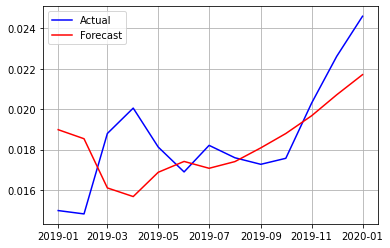

In [31]:
plt.figsize=(21,7)
plt.plot(dataUS['infUS'][-fc_len:], color = 'blue', label='Actual')
plt.plot(df_forecast['infUS_fc'], color = 'red', label='Forecast')
plt.legend()
plt.grid()
plt.savefig("var_forecast.pdf")

In [32]:
df_forecast['perc_error']=(df_forecast['infUS_fc']-dataUS['infUS'][-fc_len:])/dataUS['infUS'][-fc_len:]*100

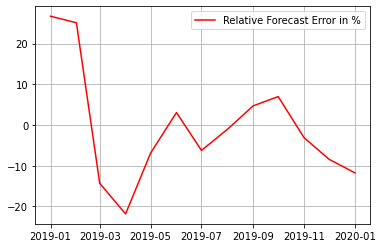

In [33]:
plt.figsize=(21,7)
plt.plot(df_forecast['perc_error'], color = 'red', label='Relative Forecast Error in %')
plt.legend()
plt.grid()
plt.savefig("var_forecast_error.pdf")

In [34]:
df_forecast

,infUS_fc,RERUS_fc,realWUS_fc,intrateUS_fc,M2US_fc,urateUS_fc,perc_error
mdate,,,,,,,
2019-01-01,0.018988,0.061968,0.016280,0.000895,0.008149,0.001677,26.728861
2019-02-01,0.018540,0.067841,0.016931,0.001006,0.010288,0.002446,25.124887
2019-03-01,0.016104,0.069405,0.019403,0.001461,0.010956,0.002353,-14.337052
2019-04-01,0.015677,0.067119,0.019910,0.002060,0.010337,0.002758,-21.836253
2019-05-01,0.016879,0.063205,0.018423,0.002138,0.010220,0.002929,-6.888242
2019-06-01,0.017415,0.056515,0.017549,0.002386,0.010576,0.003088,3.071716
2019-07-01,0.017077,0.049519,0.017959,0.002426,0.010288,0.002991,-6.232126
2019-08-01,0.017409,0.043106,0.017412,0.002431,0.010255,0.003138,-1.069464
2019-09-01,0.018088,0.035100,0.016666,0.002337,0.009876,0.002999,4.714140


### 8.2 CPI forecast

In [35]:
# load CPI data:
CPI=pd.read_csv("CPIAUCSL.csv", parse_dates=["DATE"], index_col=["DATE"])
CPI.rename(columns = {'CPIAUCSL' : 'Actual CPI'}, inplace = True)

In [36]:
# selecting the last 12 months before the forecast,
# because inflation is the change in price of this year's month compared to last year's month.
ts_last= time_split
ts_cpi_start= time_split-relativedelta(years=1)
last_cpi=CPI.loc[CPI.index>=ts_cpi_start]
last_cpi = last_cpi.loc[last_cpi.index<time_split]

In [37]:
cpi_fc=[]
for i in range(len(df_forecast)):
    if i<12:
        cpi_fc.append(last_cpi['Actual CPI'][i]*(1+df_forecast['infUS_fc'][i]))
    else:
        cpi_fc.append(cpi_fc[i-12]*(1+df_forecast['infUS_fc'][i]))

In [38]:
df_cpi_fc=pd.DataFrame(index = df_forecast.index , data = {'cpi_fore': cpi_fc})

In [39]:
df_cpi_valid = CPI.loc[df_forecast.index]

In [40]:
df_cpi_valid['Forecast CPI']=cpi_fc
df_cpi_valid['rel error CPI'] = (df_cpi_valid['Forecast CPI']-df_cpi_valid['Actual CPI'])/df_cpi_valid['Forecast CPI']*100
df_cpi_valid

,Actual CPI,Forecast CPI,rel error CPI
DATE,,,
2019-01-01,252.470,253.466185,0.393025
2019-02-01,253.135,254.063616,0.365505
2019-03-01,254.273,253.600306,-0.265258
2019-04-01,255.163,254.067475,-0.431194
2019-05-01,255.325,255.011861,-0.122794
2019-06-01,255.361,255.491333,0.051013
2019-07-01,255.900,255.614756,-0.111592
2019-08-01,256.179,256.131623,-0.018497
2019-09-01,256.596,256.801395,0.079982


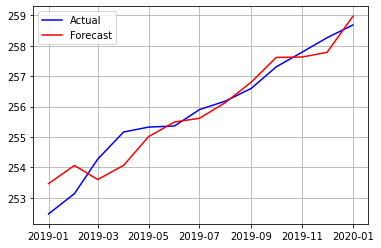

In [41]:
plt.figsize=(21,7)
plt.plot(df_cpi_valid['Actual CPI'], color = 'blue', label='Actual')
plt.plot(df_cpi_valid['Forecast CPI'], color = 'red', label='Forecast')
plt.legend()
plt.grid()
plt.savefig("var_CPI_forecast.pdf")

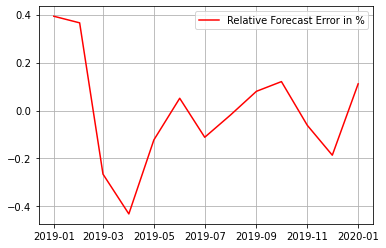

In [42]:
df_cpi_valid
plt.figsize=(21,7)
plt.plot(df_cpi_valid['rel error CPI'], color = 'red', label='Relative Forecast Error in %')
plt.legend()
plt.grid()
plt.savefig("var_CPI_forecast_error.pdf")

## 9. Evaluate forecast

In [43]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    rrmse = np.mean((forecast - actual)**2/(forecast)**2)**.5 # Relative RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'Relative RMSE':rrmse,
            'corr':corr, 'minmax':minmax})

### 9.1 Inflation evalution

In [44]:
print('Forecast Accuracy of Inflation in the USA')
accuracy_prod = forecast_accuracy(df_forecast['infUS_fc'].values, valid['infUS'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of Inflation in the USA
mape   :  0.1079
me     :  -0.0004
mae    :  0.002
mpe    :  -0.0054
rmse   :  0.0024
Relative RMSE :  0.1345
corr   :  0.4846
minmax :  0.0991


C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


### 9.1 CPI evalution

In [45]:
print('Forecast Accuracy of Inflation in the USA')
accuracy_prod = forecast_accuracy(df_cpi_valid['Forecast CPI'], df_cpi_valid['Actual CPI'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of Inflation in the USA
mape   :  0.0018
me     :  -0.015
mae    :  0.4548
mpe    :  -0.0001
rmse   :  0.5673
Relative RMSE :  0.0022
corr   :  0.9497
minmax :  0.0018


C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\JEROME~1\AppData\Local\Temp/ipykernel_16280/1290597128.py:13: FutureWarning: Support for multi-dimensional index